# "Implémentez un modèle de scoring"
_Merging data tables_


References used for this notebook:

- "https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda"
- 

## Setup

### Importing Packages and Modules

In [1]:
from P7_functions import *

c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Imports

In [2]:
import io
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

Display options.

In [3]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

### Read data

In [4]:
import os
os.getcwd()

'c:\\Users\\adam_\\Desktop\\OC\\Project 07\\Project-07a-Model'

In [11]:
path_data = '../data/raw'

In [7]:
# os.walk(path_data)

<generator object walk at 0x00000122825552C8>

In [12]:
# get the name of all the .csv files in the 'DATA' directory

li_files = []
for n_dir, _, n_files in os.walk(path_data):
    li_files = n_files
    print(n_dir, li_files)
li_files = sorted(li_files)

../data/raw ['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [13]:
li_key_names = ['home_cred_desc','pos_cash_bal','app_test','app_train','bur',
                'bur_bal','ccard_bal','install_pay','prev_app','samp_subm']
dict_df = {}

In [14]:
for k, n_file in zip(li_key_names, li_files):
    print(k, n_file)
    dict_df[k] = pd.read_csv(path_data+'\\'+ n_file, encoding = "ISO-8859-1")

home_cred_desc HomeCredit_columns_description.csv
pos_cash_bal POS_CASH_balance.csv
app_test application_test.csv
app_train application_train.csv
bur bureau.csv
bur_bal bureau_balance.csv
ccard_bal credit_card_balance.csv
install_pay installments_payments.csv
prev_app previous_application.csv
samp_subm sample_submission.csv


In [15]:
dict_df.keys()

dict_keys(['home_cred_desc', 'pos_cash_bal', 'app_test', 'app_train', 'bur', 'bur_bal', 'ccard_bal', 'install_pay', 'prev_app', 'samp_subm'])

## Overview

#### Size

In [16]:
# Have a overview of the content

for k, df in dict_df.items():
    display(f"{k}: {df.shape}")

'home_cred_desc: (219, 5)'

'pos_cash_bal: (10001358, 8)'

'app_test: (48744, 121)'

'app_train: (307511, 122)'

'bur: (1716428, 17)'

'bur_bal: (27299925, 3)'

'ccard_bal: (3840312, 23)'

'install_pay: (13605401, 8)'

'prev_app: (1670214, 37)'

'samp_subm: (48744, 2)'

#### Primary keys

In [17]:
dict_df['app_train'].columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [18]:
dict_df['app_train']['SK_ID_CURR'].is_unique

True

In [19]:
# check the primary ids in the columns of each table

for n_table, n_file in zip(li_key_names, li_files):
    print('--', n_file)
    print([col for col in dict_df[n_table].columns if dict_df[n_table][col].is_unique])

-- HomeCredit_columns_description.csv
['Unnamed: 0']
-- POS_CASH_balance.csv
[]
-- application_test.csv
['SK_ID_CURR']
-- application_train.csv
['SK_ID_CURR']
-- bureau.csv
['SK_ID_BUREAU']
-- bureau_balance.csv
[]
-- credit_card_balance.csv
[]
-- installments_payments.csv
[]
-- previous_application.csv
['SK_ID_PREV']
-- sample_submission.csv
['SK_ID_CURR']


### Missing values

In [ ]:
# Missing values

df_missing = pd.DataFrame()
for n_df, df in dict_df.items():
    df_missing = pd.concat([df_missing,
                            missing_data(df)['Percent'].to_frame(name=n_df)],
                           axis=1)

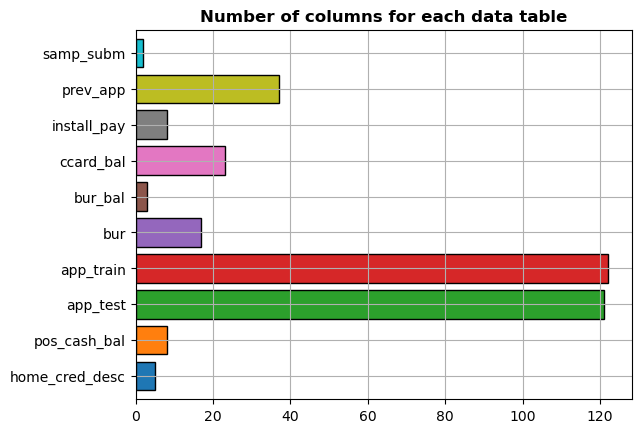

In [21]:
# number of columns of each data table

colors = sns.color_palette('tab10')[:df_missing.shape[0]]
df_missing.count().plot.barh(ec='k', color=colors, width=0.8)
plt.title('Number of columns for each data table', fontweight='bold')
plt.grid()

In [22]:
# rearrange the ratio of missing values in each columns

df_missing_pct = df_missing.T.stack().reset_index()
df_missing_pct.columns = ['data_table', 'column', 'missing_pct']
df_missing_pct.sample(3)

,data_table,column,missing_pct
175,app_train,FLOORSMAX_AVG,49.76
219,app_train,FLAG_DOCUMENT_15,0.00
252,app_train,NAME_FAMILY_STATUS,0.00


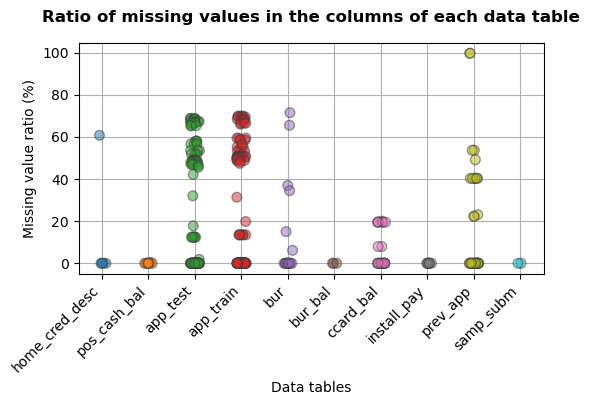

In [23]:
sns.stripplot(x='data_table', y='missing_pct', data=df_missing_pct,
              linewidth=1, alpha = 0.5, size=7)
plt.gcf().set_size_inches(6,3)
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.set_ylabel('Missing value ratio (%)')
ax.set_xlabel('Data tables')
ax.set_title('Ratio of missing values in the columns of each data table',
             fontweight='bold', pad=15)
plt.grid()

## Merging and aggregations

### Table columns descriptions

**application_train and application_test (Main tables, ou r train ans test samples | target | info about loan and loan applicant at application time))**

Many operations for each customer : 
- CREDIT_ACTIVE : If the credit has been totally payed
- DAYS_CREDIT : Number of days since the last demand
- CREDIT_DAY_OVERDUE : Number of days of late payment
- DAYS_CREDIT_ENDDATE : Days left before end of credit. Negative if credit has ended.  (positive and negative values give the same information as CREDIT_ACTIVE)
- DAYS_ENDDATE_FACT : End of credit date. (same information than DAYS_CREDIT_ENDDATE)
- AMT_CREDIT_MAX_OVERDUE : Total amount of overdue
- CNT_CREDIT_PROLONG Nombre : Number of times the credit has been delayed
- AMT_CREDIT_SUM : Total sum of the bureau loan
- AMT_CREDIT_SUM_DEBT : Sum left to pay
- AMT_CREDIT_SUM_LIMIT : Limit amount autorized for the loan
- AMT_CREDIT_SUM_OVERDUE : Amount of actual overdue
- CREDIT_TYPE : Kind of way to pay
- DAYS_CREDIT_UPDATE : Last update of informations
- AMT_ANNUITY : Amount payed each year 

**bureau_balance (Monthly balance of credits in Credit Bureau)**

MONTHS_BALANCE : Months of installment for application <br>
STATUS : If number, number of months of failure to pay

**bureau (Appliation data from previous loans that client got from other institutions ans that were reported to Credit Bureau)**





Equivalent of Bureau table, which list the credits the customer had in Home Credit, a the main information about it.<br>
- NAME_CONTRACT_TYPE, 
- AMT_ANNUITY : total anual repay
- AMT_APPLICATION : how much asked, 
- AMT_CREDIT : total credit, 
- AMT_GOODS_PRICE : total of the good to buy (can be correlated to AMT_ANNUITY),
- WEEKDAY_APPR_PROCESS_START : day in which the client asked, 
- HOUR_APPR_PROCESS_START : hour in which the client applied,
- FLAG_LAST_APPL_PER_CONTRACT' : sometimes the client askedagain after being aproved, 
- NFLAG_LAST_APPL_IN_DAY : if the client contract or try an other credit in the same day,
- NAME_CASH_LOAN_PURPOSE : purpose,
- NAME_CONTRACT_STATUS : If approved or refused, 
- DAYS_DECISION : number of days to make the decision, 
- NAME_PAYMENT_TYPE : payment type,
- CODE_REJECT_REASON' : reject reason, 
- NAME_TYPE_SUITE : who accompagned client, 
- NAME_CLIENT_TYPE : old or new client,
- NAME_GOODS_CATEGORY : product bought, 
- NAME_PORTFOLIO : cash, pos, or car, 
- NAME_PRODUCT_TYPE,
- CHANNEL_TYPE : way to attract client, 
- CNT_PAYMENT : end of the last payment when asked, ,
- DAYS_FIRST_DRAWING : olest diturbance in last application, 
- DAYS_FIRST_DUE : Supposed first due of previous credit,
- DAYS_LAST_DUE_1ST_VERSION: first due of previous credit, 
- DAYS_LAST_DUE : date last due, 
- DAYS_TERMINATION : date supposed last due, 
- NFLAG_INSURED_ON_APPROVAL : requested an insurance or not






**POS_CASH_balance (Monthly balance of clients previous loans in Home Credit)**


- MONTHS_BALANCE : month of balance from application
- CNT_INSTALMENT : Term of previous credit
- CNT_INSTALMENT_FUTURE : Number of installment left to pay
- NAME_CONTRACT_STATUS : active or not
- SK_DPD : days past due on the month
- SK_DPD_DEF : day past du where the small mounth or small date are removed / tolerated


**credit_card_balance (Monthly balance of clients previous credit card loans in Home Credit)**


- MONTHS_BALANCE : Month of the balance from application
- AMT_BALANCE : amount of the balance for the month
- AMT_CREDIT_LIMIT_ACTUAL : credit card limit during the month
- AMT_DRAWINGS_ATM_CURRENT : amount taken at ATM with the credit card
- AMT_DRAWINGS_CURRENT : Amount used with the credit card
- AMT_DRAWINGS_OTHER_CURRENT :other amount use with the creedit card ? 
- AMT_DRAWINGS_POS_CURRENT : amount taken from AMT or bought during the month
- AMT_INST_MIN_REGULARITY : minimal installment
- AMT_PAYMENT_CURRENT : Payement for the month
- AMT_PAYMENT_TOTAL_CURRENT : Total payment for the month ? 
- CNT_DRAWINGS_ATM_CURRENT : number of drawing at ATM
- CNT_DRAWINGS_CURRENT : number of use of credit card
- CNT_DRAWINGS_OTHER_CURRENT : number of other use of credit card ?
- CNT_DRAWINGS_POS_CURRENT : total number of use during the month
- CNT_INSTALMENT_MATURE_CUM : number of payed installments
- NAME_CONTRACT_STATUS : active or not
- SK_DPD : days past due on the month
- SK_DPD_DEF : day past du where the small mounth or small date are removed / tolerated


**POS_CASH_BALANCE (monthly balance of clients' previous loans in Home Credit)**


Common features to POS and Credit, linked to specific installments
- NUM_INSTALMENT_VERSION : version of installment
- NUM_INSTALMENT_NUMBER : which installment is considered
- DAYS_INSTALMENT : When was the installment supposed to be payed
- DAYS_ENTRY_PAYMENT : When was it payed
- AMT_INSTALMENT : Which amount was supposed to be payed
- AMT_PAYMENT : How much was actually payed

**installments_payments (Past payment data for each installmants of previous credits in Home Credit related to loans in our sample)**

- SK_ID_PREV
- SK_ID_CURR
- NUM_INSTALMENT_VERSION
- NUM_INSTALMENT_NUMBER
- DAYS_INSTALMENT
- DAYS_ENTRY_PAYMENT
- AMT_INSTALMENT
- AMT_PAYMENT

**previous_application (Application data of clients previous loans in Home Credit)**

SK_ID_PREV
SK_ID_CURR
NAME_CONTRACT_TYPE
AMT_ANNUITY
AMT_APPLICATION
AMT_CREDIT
AMT_DOWN_PAYMENT
AMT_GOODS_PRICE
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
FLAG_LAST_APPL_PER_CONTRACT
NFLAG_LAST_APPL_IN_DAY
RATE_DOWN_PAYMENT
RATE_INTEREST_PRIMARY
RATE_INTEREST_PRIVILEGED
NAME_CASH_LOAN_PURPOSE
NAME_CONTRACT_STATUS
DAYS_DECISION
NAME_PAYMENT_TYPE
CODE_REJECT_REASON
NAME_TYPE_SUITE
NAME_CLIENT_TYPE
NAME_GOODS_CATEGORY
NAME_PORTFOLIO
NAME_PRODUCT_TYPE
CHANNEL_TYPE
SELLERPLACE_AREA
NAME_SELLER_INDUSTRY
CNT_PAYMENT
NAME_YIELD_GROUP
PRODUCT_COMBINATION
DAYS_FIRST_DRAWING
DAYS_FIRST_DUE
DAYS_LAST_DUE_1ST_VERSION
DAYS_LAST_DUE
DAYS_TERMINATION
NFLAG_INSURED_ON_APPROVAL

### Application train, test

#### Check unique values

Let's check if the unique values are correctly distributed in each categorical columns of the training and test test.

In [24]:
# loop over the object columns of the application train data table

for c in dict_df['app_train'].columns[dict_df['app_train'].dtypes == 'object']:
    c_train = set(dict_df['app_train'][c].unique())
    c_test = set(dict_df['app_test'][c].unique())
    diff = c_train ^ c_test
    len_diff = len(list(c_train)) - len(list(c_test))
    if len(diff) > 0:
        print('feature ' + c + \
' has DIFFERENT values in training set and test set: ---->  ', diff)
        print(len_diff, 'extra values in TRAIN') if len_diff > 0 else print(len_diff, 'Extra values in TEST') 
    else:
        print(f'{c} OK: same unique values in training set and test set')

NAME_CONTRACT_TYPE OK: same unique values in training set and test set
feature CODE_GENDER has DIFFERENT values in training set and test set: ---->   {'XNA'}
1 extra values in TRAIN
FLAG_OWN_CAR OK: same unique values in training set and test set
FLAG_OWN_REALTY OK: same unique values in training set and test set
NAME_TYPE_SUITE OK: same unique values in training set and test set
feature NAME_INCOME_TYPE has DIFFERENT values in training set and test set: ---->   {'Maternity leave'}
1 extra values in TRAIN
NAME_EDUCATION_TYPE OK: same unique values in training set and test set
feature NAME_FAMILY_STATUS has DIFFERENT values in training set and test set: ---->   {'Unknown'}
1 extra values in TRAIN
NAME_HOUSING_TYPE OK: same unique values in training set and test set
OCCUPATION_TYPE OK: same unique values in training set and test set
WEEKDAY_APPR_PROCESS_START OK: same unique values in training set and test set
ORGANIZATION_TYPE OK: same unique values in training set and test set
FONDKAPR

In [25]:
# harmonize unique values in 'app_train' and 'app_test'

dict_df['app_train']['CODE_GENDER'] = \
    dict_df['app_train']['CODE_GENDER'].map(lambda x: x if x != 'XNA' else np.nan)
dict_df['app_train']['NAME_INCOME_TYPE'] = \
    dict_df['app_train']['NAME_INCOME_TYPE'].map(lambda x: x if x != 'Maternity leave' else np.nan)
dict_df['app_train']['NAME_FAMILY_STATUS'] = \
    dict_df['app_train']['NAME_FAMILY_STATUS'].map(lambda x: x if x != 'Unknown' else np.nan)

#### dropping quantitative features with small variance

training set

In [28]:
# # Checking feature with std greater than 0.01 (relative) 

# df_desc = dict_df['app_train'].describe().T
# df_desc = df_desc.assign(rel_std=df_desc['std']/(df_desc['max']-df_desc['min']))
# low_var_cols_train = df_desc[df_desc['rel_std']<0.01].index
# df_desc.loc[low_var_cols_train]

In [29]:
# # Selection of feature with std greater than 0.01 (absolute) 

# df_num = dict_df['app_train'].select_dtypes(include=[np.number])
# mask_cols = (df_num.std(axis = 0) < .01).values
# low_var_cols_train = df_num.columns[mask_cols]
# dict_df['app_train'][low_var_cols_train].describe().T

test set

In [30]:
# # Checking feature with std greater than 0.01 (relative) 

# df_desc = dict_df['app_test'].describe().T
# df_desc = df_desc.assign(rel_std=df_desc['std']/(df_desc['max']-df_desc['min']))
# low_var_cols_test = df_desc[df_desc['rel_std']<0.01].index
# df_desc.loc[low_var_cols_test]

In [31]:
# # Selection of feature with std greater than 0.01 (absolute) 

# df_num = dict_df['app_test'].select_dtypes(include=[np.number])
# mask_cols = (df_num.std(axis = 0) < .01).values
# low_var_cols_test = df_num.columns[mask_cols]
# dict_df['app_test'][low_var_cols_test].describe().T

In [32]:
# # Drop all the columns with low absolute variance
# low_var_cols = list(set(low_var_cols_train) | set(low_var_cols_test))
# print(low_var_cols)

In [33]:
# dict_df['app_train'] = dict_df['app_train'].drop(columns=low_var_cols)
# dict_df['app_test'] = dict_df['app_test'].drop(columns=low_var_cols)
# print(dict_df['app_train'].shape, dict_df['app_test'].shape) # 0.1585

In [26]:
set(dict_df['app_train'].columns) - set(dict_df['app_test'].columns)

{'TARGET'}

### bureau_balance -> bureau

In [27]:
dict_df['bur_bal']['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [28]:
# Change 0 to 'N' in STATUS

dict_df['bur_bal'].loc[:,'STATUS'] = \
    dict_df['bur_bal'].loc[:,'STATUS'].replace({'0': 'N'})

In [29]:
# copy content of STATUS in a new column and replace letters with 0

dict_df['bur_bal']['STATUS_MONTHS_FAIL'] = \
                pd.to_numeric(dict_df['bur_bal']['STATUS'],
                            errors='coerce').fillna(0)

In [30]:
# keep categorical values in STATUS, change numbers to 'F'

mask = pd.to_numeric(dict_df['bur_bal']['STATUS'],
                     errors='coerce').notna()

dict_df['bur_bal'].loc[mask, 'STATUS'] = 'F'

In [31]:
# check quantitative variables with less than 0.01 absolute std

dict_df['bur_bal'].describe().loc['std'] < .01

SK_ID_BUREAU          False
MONTHS_BALANCE        False
STATUS_MONTHS_FAIL    False
Name: std, dtype: bool

In [32]:
dict_df['bur_bal'].columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS', 'STATUS_MONTHS_FAIL'], dtype='object')

#### Bureau: loading, converting to numeric, dropping

In [33]:
# check quantitative variables with less than 0.01 absolute std

dict_df['bur'].describe().loc['std'] < .01

SK_ID_CURR                False
SK_ID_BUREAU              False
DAYS_CREDIT               False
CREDIT_DAY_OVERDUE        False
DAYS_CREDIT_ENDDATE       False
DAYS_ENDDATE_FACT         False
AMT_CREDIT_MAX_OVERDUE    False
CNT_CREDIT_PROLONG        False
AMT_CREDIT_SUM            False
AMT_CREDIT_SUM_DEBT       False
AMT_CREDIT_SUM_LIMIT      False
AMT_CREDIT_SUM_OVERDUE    False
DAYS_CREDIT_UPDATE        False
AMT_ANNUITY               False
Name: std, dtype: bool

#### agregating Bureau_balance features

In [34]:
print(dict_df['bur_bal'].columns)

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'STATUS', 'STATUS_MONTHS_FAIL'], dtype='object')


In [35]:
# aggregate along 'SK_ID_BUREAU'

def abs_min(x): return np.abs(np.min(x))
def mode(x): return x.mode()[0]

li_agg = {'MONTHS_BALANCE': [abs_min],
          'STATUS': [mode, 'size'],
          'STATUS_MONTHS_FAIL': ['mean', 'max']}

dict_df['bur_bal'] = dict_df['bur_bal'].groupby('SK_ID_BUREAU').agg(li_agg)

In [36]:
# flatten two levels columns indices

dict_df['bur_bal'].columns = ['__'.join(tup).strip() \
                                for tup in dict_df['bur_bal'].columns.values]

In [37]:
dict_df['bur_bal'].head()

,MONTHS_BALANCE__abs_min,STATUS__mode,STATUS__size,STATUS_MONTHS_FAIL__mean,STATUS_MONTHS_FAIL__max
SK_ID_BUREAU,,,,,
5001709,96,C,97,0.00,0.00
5001710,82,C,83,0.00,0.00
5001711,3,N,4,0.00,0.00
5001712,18,N,19,0.00,0.00
5001713,21,X,22,0.00,0.00


#### merging bureau_balance in to into bureau

In [38]:
# merge 'bur_bal' into 'bur'

dict_df['bur'] = dict_df['bur'].merge(dict_df['bur_bal'],
                                      how='left',
                                      on='SK_ID_BUREAU')

In [39]:
# add prefix to the name of the columns

dict_df['bur'].columns = ['CB_'+col if col not in ['SK_ID_BUREAU',
                                                  'SK_ID_CURR'] \
                            else col for col in dict_df['bur'].columns]

In [40]:
dict_df['bur'].head()

,SK_ID_CURR,SK_ID_BUREAU,CB_CREDIT_ACTIVE,CB_CREDIT_CURRENCY,CB_DAYS_CREDIT,CB_CREDIT_DAY_OVERDUE,CB_DAYS_CREDIT_ENDDATE,CB_DAYS_ENDDATE_FACT,CB_AMT_CREDIT_MAX_OVERDUE,CB_CNT_CREDIT_PROLONG,...,CB_AMT_CREDIT_SUM_LIMIT,CB_AMT_CREDIT_SUM_OVERDUE,CB_CREDIT_TYPE,CB_DAYS_CREDIT_UPDATE,CB_AMT_ANNUITY,CB_MONTHS_BALANCE__abs_min,CB_STATUS__mode,CB_STATUS__size,CB_STATUS_MONTHS_FAIL__mean,CB_STATUS_MONTHS_FAIL__max
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,...,NaN,0.00,Consumer credit,-131,NaN,NaN,NaN,NaN,NaN,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.00,NaN,NaN,0,...,NaN,0.00,Credit card,-20,NaN,NaN,NaN,NaN,NaN,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,...,NaN,0.00,Consumer credit,-16,NaN,NaN,NaN,NaN,NaN,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,...,NaN,0.00,Credit card,-16,NaN,NaN,NaN,NaN,NaN,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.00,NaN,77674.50,0,...,NaN,0.00,Consumer credit,-21,NaN,NaN,NaN,NaN,NaN,NaN


### PREVIOUS LOANS in HOME CREDIT

'previous_application', describes the previous loans in Home Credit.

'POS_CASH_balance', 'installments_payments' and 'credit_card_balance' gives details on these loans (to be merged with 'previous_application')

#### POS_CASH_balance -> previous_applications

In [41]:
# harmonize unique values with other tables

dict_df['prev_app']['NAME_CONTRACT_STATUS'] = \
                dict_df['pos_cash_bal']['NAME_CONTRACT_STATUS']\
                            .map(lambda x: x if x != 'XNA' else np.nan)
dict_df['pos_cash_bal']['NAME_CONTRACT_STATUS'] = \
                dict_df['pos_cash_bal']['NAME_CONTRACT_STATUS']\
                            .map(lambda x: x if x != 'XNA' else np.nan)

In [42]:
# One Hot Encoding of status contract for each

dict_df['pos_cash_bal'] = pd.get_dummies(dict_df['pos_cash_bal'],
                                         prefix='N_CONTR_ST',
                                         columns=['NAME_CONTRACT_STATUS'])

In [43]:
# aggregate along 'SK_ID_PREV'

def abs_min(x): return np.abs(np.min(x))

li_agg = {'MONTHS_BALANCE': [abs_min],
          'CNT_INSTALMENT': ['max'], # nb of changes in the instalment parameters
          'CNT_INSTALMENT_FUTURE': ['max'], # maximum number of instalments 
          'N_CONTR_ST_Active': ['sum'],
          'N_CONTR_ST_Completed': ['sum'],
          'N_CONTR_ST_Signed': ['sum'],
          'N_CONTR_ST_Demand': ['sum'],
          'N_CONTR_ST_Returned to the store': ['sum'],
          'N_CONTR_ST_Approved': ['sum'],
          'N_CONTR_ST_Amortized debt': ['sum'],
          'N_CONTR_ST_Canceled': ['sum'],
          'SK_DPD': ['mean'], # days past due
          'SK_DPD_DEF': ['mean'], # days past due with tolerance
          }

dict_df['pos_cash_bal'] = \
            dict_df['pos_cash_bal'].groupby('SK_ID_PREV').agg(li_agg)

In [44]:
# flatten two levels columns indices

dict_df['pos_cash_bal'].columns = ['__'.join(tup).strip() \
                             for tup in dict_df['pos_cash_bal'].columns.values]

In [45]:
# add prefix to the name of the columns before merging (PrL: previous loan)

dict_df['pos_cash_bal'].columns = ['PrLCash_'+col if col not in ['SK_ID_BUREAU',
                                                  'SK_ID_CURR'] \
                                  else col for col in dict_df['pos_cash_bal'].columns ]

In [46]:
# merge 'pos_cash_bal' with 'prev_app'

dict_df['prev_app'] = dict_df['prev_app'].merge(dict_df['pos_cash_bal'],
                                                how='left',
                                                on='SK_ID_PREV')

#### installments_payments -> previous_applications

In [47]:
# assign a new feature: delay for the payment of each installment

dict_df['install_pay'] = \
        dict_df['install_pay'].assign(DELAY_DAYS_INSTALMENT=\
                                    lambda x: x['DAYS_ENTRY_PAYMENT']-\
                                              x['DAYS_INSTALMENT'])

# drop the columns 'days'

dict_df['install_pay'] = \
                dict_df['install_pay'].drop(columns=['DAYS_INSTALMENT',
                                                     'DAYS_ENTRY_PAYMENT'])

In [48]:
# aggregate along 'SK_ID_PREV'

def amp(x): return (np.max(x) - np.min(x))

li_agg = {
          'NUM_INSTALMENT_VERSION': ['max'], # nb of changes in the instalment parameters
          'NUM_INSTALMENT_NUMBER': ['max'], # maximum number of instalments 
          'AMT_INSTALMENT': ['mean', 'sum', amp, 'max', 'size'], # amount of installments
          'AMT_PAYMENT': ['sum'], # to check the amount of unpaid loans
          'DELAY_DAYS_INSTALMENT': ['mean', amp, 'max'], # delay for payment
          }

dict_df['install_pay'] = \
                     dict_df['install_pay'].groupby('SK_ID_PREV').agg(li_agg)

In [49]:
# flatten two levels columns indices

dict_df['install_pay'].columns = ['__'.join(tup).strip() \
                             for tup in dict_df['install_pay'].columns.values]

In [50]:
dict_df['install_pay'] = dict_df['install_pay'].reset_index()

In [51]:
# add prefix to the name of the columns before merging (PrLI: previous loan installment)

dict_df['install_pay'].columns = ['PrLI_'+col if col not in ['SK_ID_PREV'] \
                            else col for col in dict_df['install_pay'].columns]

In [52]:
# merge 'install_pay' into 'prev_app'

dict_df['prev_app'] = dict_df['prev_app'].merge(dict_df['install_pay'],
                                                how='left',
                                                on='SK_ID_PREV')

#### credit_card_balance -> previous_applications

In [53]:
# drop redundant columns

dict_df['ccard_bal'] = dict_df['ccard_bal']\
    .drop(columns=['AMT_PAYMENT_CURRENT',
                   'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE',
                   'CNT_DRAWINGS_ATM_CURRENT','CNT_DRAWINGS_POS_CURRENT',
                   'CNT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_ATM_CURRENT',
                   'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT'
                   ])

In [54]:
# One Hot Encoding of status contract for each

dict_df['ccard_bal'] = pd.get_dummies(dict_df['ccard_bal'],
                                      prefix='N_CONTR_ST',
                                      columns=['NAME_CONTRACT_STATUS'])

In [55]:
# find the AMT_CREDIT_LIMIT for the last month (to merge to the aggregated dataframe later)

ind = dict_df['ccard_bal'].groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
ser_last_AMT_CREDIT_LIMIT_ACTUAL = dict_df['ccard_bal'].loc[ind, ['SK_ID_PREV',
                                                                  'AMT_CREDIT_LIMIT_ACTUAL']]
ser_last_AMT_CREDIT_LIMIT_ACTUAL = \
                    ser_last_AMT_CREDIT_LIMIT_ACTUAL.set_index('SK_ID_PREV')
ser_last_AMT_CREDIT_LIMIT_ACTUAL.columns = ['AMT_CREDIT_LIMIT_ACTUAL_last']

In [56]:
# aggregate along 'SK_ID_PREV'

li_agg = {
          'MONTHS_BALANCE': [abs_min, 'size'],
          'AMT_BALANCE': [amp, 'max', 'mean'],
          'AMT_CREDIT_LIMIT_ACTUAL': ['mean'],
          'AMT_DRAWINGS_CURRENT': ['mean'],
          'AMT_INST_MIN_REGULARITY': ['mean'],
          'AMT_PAYMENT_TOTAL_CURRENT': [amp, 'max', 'mean'],
          'AMT_TOTAL_RECEIVABLE': [amp, 'max', 'mean'],
          'CNT_DRAWINGS_CURRENT': [amp, 'max', 'mean'],
          'CNT_INSTALMENT_MATURE_CUM': ['max'], # nb of paid installments 
          'N_CONTR_ST_Active': ['sum'],
          'N_CONTR_ST_Completed': ['sum'],
          'N_CONTR_ST_Signed': ['sum'],
          'N_CONTR_ST_Demand': ['sum'],
          'N_CONTR_ST_Refused': ['sum'],
          'N_CONTR_ST_Approved': ['sum'],   
          'N_CONTR_ST_Sent proposal': ['sum'],
          'SK_DPD': ['mean'], # days past due
          'SK_DPD_DEF': ['mean'], # days past due with tolerance
          }

dict_df['ccard_bal'] = \
                     dict_df['ccard_bal'].groupby('SK_ID_PREV').agg(li_agg)

In [57]:
# flatten two levels columns indices

dict_df['ccard_bal'].columns = ['__'.join(tup).strip() \
                             for tup in dict_df['ccard_bal'].columns.values]

In [58]:
dict_df['ccard_bal'] = dict_df['ccard_bal'].reset_index()

In [59]:
# add the last amount credit limit

dict_df['ccard_bal'] = \
                    dict_df['ccard_bal'].merge(ser_last_AMT_CREDIT_LIMIT_ACTUAL,
                                               'left', on='SK_ID_PREV')

In [60]:
# add prefix to the name of the columns before merging (PrLC: previous loan credit card)

dict_df['ccard_bal'].columns = ['PrLC_'+col if col not in ['SK_ID_PREV'] \
                            else col for col in dict_df['ccard_bal'].columns]

In [61]:
# merge 'ccard_bal' into 'prev_app'

dict_df['prev_app'] = dict_df['prev_app'].merge(dict_df['ccard_bal'],
                                           how='left',
                                           on='SK_ID_PREV')

In [62]:
dict_df['prev_app'].shape

(1670214, 89)

### bureau -> application_train/test

In [63]:
# drop the currency column

dict_df['bur'] = dict_df['bur'].drop(columns=['CB_CREDIT_CURRENCY'])

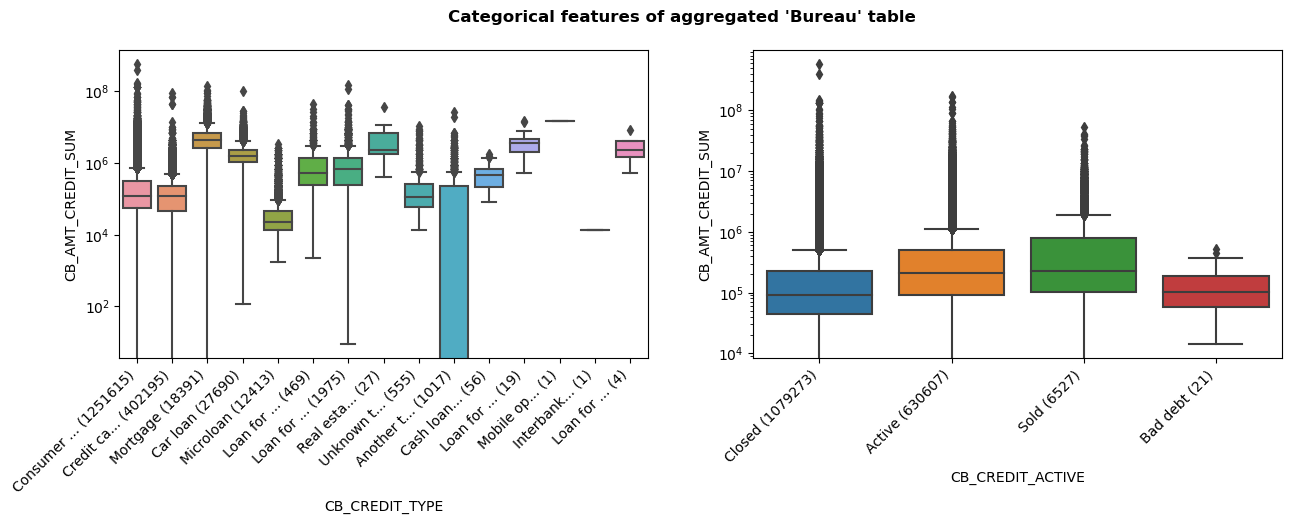

In [64]:
# Check the categories of loans reported to the Credit Bureau

fig = plt.figure(figsize=(15,4))

ax1 = fig.add_subplot(1,2,1)
plot_boxplot_categories(dict_df['bur'], col_cat = 'CB_CREDIT_TYPE', ax=ax1,
                        col_val = 'CB_AMT_CREDIT_SUM', n_sh=10, log_scale=True)
ax2 = fig.add_subplot(1,2,2)
plot_boxplot_categories(dict_df['bur'], col_cat = 'CB_CREDIT_ACTIVE', ax=ax2,
                        col_val = 'CB_AMT_CREDIT_SUM', n_sh=10, log_scale=True)
plt.suptitle("Categorical features of aggregated 'Bureau' table",
             fontweight='bold')
plt.show()

In [65]:
# replace similar values

dict_df['bur']['CB_CREDIT_TYPE'] = \
    dict_df['bur']['CB_CREDIT_TYPE'].replace(['Another type of loan',
                                            'Unknown type of loan',
                                            'Cash loan (non-earmarked)',
                                            'Mobile operator loan',
                                            'Interbank credit'],
                                            np.nan)
dict_df['bur']['CB_CREDIT_TYPE'] = \
    dict_df['bur']['CB_CREDIT_TYPE'].replace(['Loan for business development',
                                            'Loan for the purchase of equipment',
                                            'Loan for purchase of shares (margin lending)'],
                                            'Loan for business development')
dict_df['bur']['CB_CREDIT_TYPE'] = \
    dict_df['bur']['CB_CREDIT_TYPE'].replace(['Real estate loan',
                                            'Mortgage'],
                                            'Mortgage')

In [66]:
# One Hot Encoding of status contract for each 'CB_CREDIT_TYPE'

dict_df['bur'] = pd.get_dummies(dict_df['bur'],
                                prefix='CB_CR_TY',
                                columns=['CB_CREDIT_TYPE'])

In [67]:
# One Hot Encoding of status contract for each 'CB_CREDIT_ACTIVE'

dict_df['bur'] = pd.get_dummies(dict_df['bur'],
                                prefix='CB_CR_ACT',
                                columns=['CB_CREDIT_ACTIVE'])

In [68]:
# One Hot Encoding of status contract for each 'CB_STATUS__mode'

dict_df['bur'] = pd.get_dummies(dict_df['bur'],
                                prefix='CB_ST__mode',
                                columns=['CB_STATUS__mode'])

In [69]:
dict_df['bur'] = dict_df['bur'].drop(columns=['CB_DAYS_CREDIT_UPDATE'])

In [70]:
dict_df['bur'].sample(3)

,SK_ID_CURR,SK_ID_BUREAU,CB_DAYS_CREDIT,CB_CREDIT_DAY_OVERDUE,CB_DAYS_CREDIT_ENDDATE,CB_DAYS_ENDDATE_FACT,CB_AMT_CREDIT_MAX_OVERDUE,CB_CNT_CREDIT_PROLONG,CB_AMT_CREDIT_SUM,CB_AMT_CREDIT_SUM_DEBT,...,CB_CR_TY_Microloan,CB_CR_TY_Mortgage,CB_CR_ACT_Active,CB_CR_ACT_Bad debt,CB_CR_ACT_Closed,CB_CR_ACT_Sold,CB_ST__mode_C,CB_ST__mode_F,CB_ST__mode_N,CB_ST__mode_X
552835,175428,5047419,-326,0,770.00,NaN,0.00,0,367990.65,278509.59,...,0,0,1,0,0,0,0,0,0,0
1252370,107468,6618535,-1855,0,-1544.00,-1544.00,5533.74,0,54720.00,0.00,...,0,0,0,0,1,0,1,0,0,0
683583,208562,5308815,-1568,0,NaN,-272.00,0.00,0,50850.00,0.00,...,0,0,0,0,1,0,0,0,0,0


In [71]:
# aggregate along 'SK_ID_CURR'

li_agg = {'CB_DAYS_CREDIT': [abs_min],
          'CB_CREDIT_DAY_OVERDUE': ['sum','max'], # days past due
          'CB_DAYS_CREDIT_ENDDATE': ['max'], # max remaining duration of credit
          'CB_DAYS_ENDDATE_FACT': ['min'], # delay since last
          'CB_AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'], # max amount overdue
          'CB_CNT_CREDIT_PROLONG': ['mean'], # nb of times credit was prolongated
          'CB_AMT_CREDIT_SUM': ['mean', 'sum'],
          'CB_AMT_CREDIT_SUM_DEBT': ['sum'],
          'CB_AMT_CREDIT_SUM_LIMIT': ['sum'],
          'CB_AMT_CREDIT_SUM_OVERDUE': ['sum'],
          'CB_AMT_ANNUITY': ['mean'],
          'CB_MONTHS_BALANCE__abs_min': [amp, 'mean', 'max'], # nb of month (total duration) of the contract		
          'CB_STATUS__size': ['sum'], # nb of months (idem above), cumulated
          'CB_STATUS_MONTHS_FAIL__mean': ['mean'],
          'CB_STATUS_MONTHS_FAIL__max': ['max'],
          'CB_CR_TY_Car loan': ['sum'],
          'CB_CR_TY_Consumer credit': ['sum'],
          'CB_CR_TY_Credit card': ['sum'],
          'CB_CR_TY_Loan for business development': ['sum'],
          'CB_CR_TY_Loan for working capital replenishment': ['sum'],
          'CB_CR_TY_Microloan': ['sum'],
          'CB_CR_TY_Mortgage': ['sum'],
          'CB_CR_ACT_Active': ['sum'],
          'CB_CR_ACT_Bad debt': ['sum'],
          'CB_CR_ACT_Closed': ['sum'],
          'CB_CR_ACT_Sold': ['sum'],
          'CB_ST__mode_C': ['sum'],
          'CB_ST__mode_F': ['sum'],
          'CB_ST__mode_N': ['sum'],
          'CB_ST__mode_X': ['sum'],
          }

dict_df['bur'] = \
            dict_df['bur'].groupby('SK_ID_CURR').agg(li_agg)

In [72]:
# flatten two levels columns indices

dict_df['bur'].columns = ['__'.join(tup).strip() \
                             for tup in dict_df['bur'].columns.values]

dict_df['bur'] = dict_df['bur'].reset_index()

In [73]:
# add prefix to the name of the columns before merging (PrL: previous loan)

dict_df['bur'].columns = ['Bur_'+col if col not in ['SK_ID_BUREAU',
                                                  'SK_ID_CURR'] \
                                  else col for col in dict_df['bur'].columns ]

In [74]:
# merge 'bur' with 'app_train' and 'app_test'

dict_df['app_train'] = dict_df['app_train'].merge(dict_df['bur'],
                                                how='left',
                                                on='SK_ID_CURR')

dict_df['app_test'] = dict_df['app_test'].merge(dict_df['bur'],
                                                how='left',
                                                on='SK_ID_CURR')

In [75]:
dict_df['app_train']['SK_ID_CURR'].shape # 307511 apptrain 48744 apptest

(307511,)

### previous_application -> application_train/test

In [76]:
# drop non useful columns

useless_cols = [                    
                  'WEEKDAY_APPR_PROCESS_START',
                  'FLAG_LAST_APPL_PER_CONTRACT',
                  'NFLAG_LAST_APPL_IN_DAY',
                  'NAME_TYPE_SUITE',
                  'NAME_SELLER_INDUSTRY',
                  'NAME_YIELD_GROUP',
                  'CHANNEL_TYPE',
                  'NAME_CLIENT_TYPE',
                  'NAME_PRODUCT_TYPE',
                  'SELLERPLACE_AREA',
                  'NAME_GOODS_CATEGORY',
                  'HOUR_APPR_PROCESS_START',
                  'NAME_CASH_LOAN_PURPOSE',
                  'DAYS_FIRST_DRAWING',
                  'AMT_GOODS_PRICE',
                  'CODE_REJECT_REASON',
                  'PRODUCT_COMBINATION',
                  'NFLAG_INSURED_ON_APPROVAL'
                  ]

dict_df['prev_app'] = dict_df['prev_app'].drop(columns=useless_cols)

In [77]:
# replace XNA by np.nan in all the categorical columns

cat_cols = dict_df['prev_app'].select_dtypes(exclude=[np.number]).columns

for col in cat_cols:
    dict_df['prev_app'][col] = \
                    dict_df['prev_app'][col]\
                                .map(lambda x: x if x != 'XNA' else np.nan)

In [78]:
# drop all the lines (application) where AMT_ANNUITY is nan or AMT_CREDIT is 0

mask1 = dict_df['prev_app']['AMT_ANNUITY'].notna()
mask2 = dict_df['prev_app']['AMT_APPLICATION']>0.1
mask3 = dict_df['prev_app']['DAYS_FIRST_DUE'].notna()

dict_df['prev_app'] = dict_df['prev_app'].loc[( mask1 & mask2 & mask3)]

In [79]:
# gb = dict_df['prev_app'].groupby('SK_ID_CURR') #.select_dtypes(exclude=[np.number])

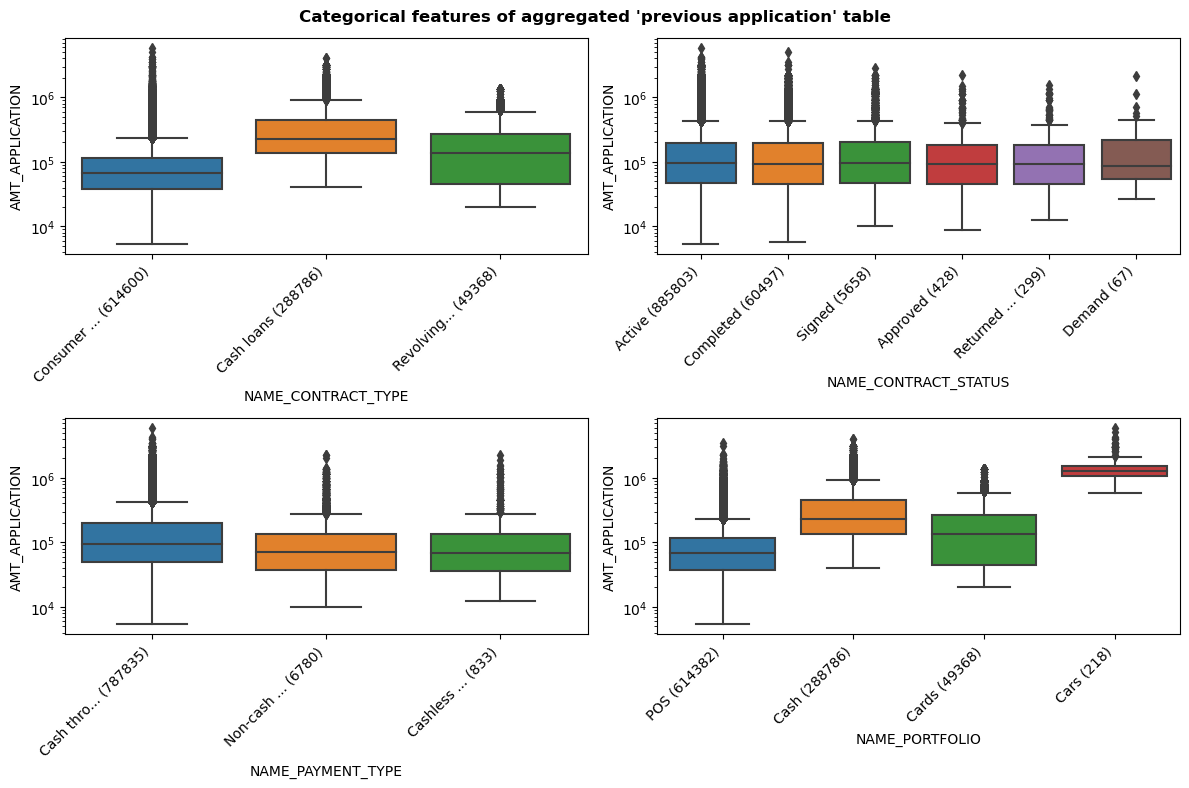

In [80]:
# Check the categories of previous loans

fig = plt.figure(figsize=(12,8))

cat_cols = dict_df['prev_app'].select_dtypes(exclude=[np.number]).columns

for i, col in enumerate(cat_cols, 1):
    ax = fig.add_subplot(2,2,i)
    plot_boxplot_categories(dict_df['prev_app'], col_cat = col, ax=ax,
                            col_val = 'AMT_APPLICATION', n_sh=10, log_scale=True)

plt.suptitle("Categorical features of aggregated 'previous application' table",
             fontweight='bold')
plt.tight_layout()
plt.show()

In [81]:
# One Hot Encoding of status contract for each 'NAME_CONTRACT_TYPE'

dict_df['prev_app'] = pd.get_dummies(dict_df['prev_app'],
                                prefix='PrL_N_CONT_Ty',
                                columns=['NAME_CONTRACT_TYPE'])

In [82]:
# One Hot Encoding of status contract for each 'NAME_CONTRACT_STATUS'

dict_df['prev_app'] = pd.get_dummies(dict_df['prev_app'],
                                prefix='PrL_N_CONT_St',
                                columns=['NAME_CONTRACT_STATUS'])

In [83]:
# One Hot Encoding of status contract for each 'NAME_PAYMENT_TYPE'

dict_df['prev_app'] = pd.get_dummies(dict_df['prev_app'],
                                prefix='PrL_N_PAY_Ty',
                                columns=['NAME_PAYMENT_TYPE'])

In [84]:
# One Hot Encoding of status contract for each 'CB_STATUS__mode'

dict_df['prev_app'] = pd.get_dummies(dict_df['prev_app'],
                                prefix='PrL_N_PORTF',
                                columns=['NAME_PORTFOLIO'])

In [85]:
# Have a overview of the missing values

missing_prevapp = missing_data(dict_df['prev_app'])['Percent'].to_frame(name=n_df)

In [86]:
# drop the columns with more than 90% nan value

col_to_keep = missing_prevapp[missing_prevapp.values<20].index
print(f"nb of columns to keep: {len(col_to_keep)}")
dict_df['prev_app'] = dict_df['prev_app'][col_to_keep]

nb of columns to keep: 51


In [87]:
all_cols = dict_df['prev_app'].columns

In [88]:
cat_cols = ['PrL_N_PORTF_POS', 'PrL_N_PORTF_Cash', 'PrL_N_CONT_Ty_Cash loans',
 'PrL_N_CONT_Ty_Consumer loans', 'PrL_N_CONT_Ty_Revolving loans',
 'PrL_N_CONT_St_Active', 'PrL_N_CONT_St_Approved', 'PrL_N_CONT_St_Completed',
 'PrL_N_CONT_St_Demand', 'PrL_N_CONT_St_Returned to the store',
 'PrL_N_CONT_St_Signed', 'PrL_N_PAY_Ty_Cash through the bank',
 'PrL_N_PAY_Ty_Cashless from the account of the employer',
 'PrL_N_PAY_Ty_Non-cash from your account', 'PrL_N_PORTF_Cards',
 'PrL_N_PORTF_Cars']
dict1 = dict(zip(cat_cols, ['sum']*len(cat_cols)))

In [89]:
other_cols = [col for col in all_cols if col not in cat_cols]

In [90]:
max_cols = [col for col in other_cols if '__max' in col]
sum_cols = [col for col in other_cols if '__sum' in col]
mean_cols = [col for col in other_cols if '__mean' in col]
abs_min_cols = [col for col in other_cols if '__abs_min' in col]
amp_cols = [col for col in other_cols if '__amp' in col]
size_cols = [col for col in other_cols if '__size' in col]

In [91]:
dict2 = dict(zip(max_cols, ['max']*len(max_cols)))
dict3 = dict(zip(sum_cols, ['sum']*len(sum_cols)))
dict4 = dict(zip(mean_cols, ['mean']*len(mean_cols)))
dict5 = dict(zip(abs_min_cols, [abs_min]*len(abs_min_cols)))
dict6 = dict(zip(amp_cols, [amp]*len(amp_cols)))
dict7 = dict(zip(size_cols, ['sum']*len(size_cols))) # sum !

In [92]:
remain_cols = [col for col in all_cols if col not in cat_cols+max_cols+sum_cols+mean_cols+amp_cols+size_cols+abs_min_cols]

In [93]:
# initial duration and effective duration of the loan

dict_df['prev_app'] = \
   dict_df['prev_app'].assign(DAYS_TOT_DURATION_INIT = \
                                lambda x: x['DAYS_LAST_DUE_1ST_VERSION'] - \
                                                        x['DAYS_FIRST_DUE'],
                                                          DAYS_TOT_DURATION = \
                                lambda x: x['DAYS_TERMINATION'] - \
                                                    x['DAYS_FIRST_DUE'])

In [94]:
# nb of days the contract has been prolongated

dict_df['prev_app'] = \
    dict_df['prev_app'].assign(DAYS_PROLONG_PCT = \
                    lambda x: 100*(x['DAYS_TOT_DURATION_INIT'] - \
                                        x['DAYS_TOT_DURATION'])/ \
                                    x['DAYS_TOT_DURATION_INIT'])

In [95]:
# difference between obtained and asked amount

dict_df['prev_app'] = \
    dict_df['prev_app'].assign(AMT_DIFF_PCT = \
                        lambda x: 100*(x['AMT_CREDIT'] - x['AMT_APPLICATION']) / \
                                x['AMT_APPLICATION'])

In [96]:
# obtained amount per month of contract 

dict_df['prev_app'] = \
    dict_df['prev_app'].assign(AMT_PER_MONTH = \
                        lambda x: x['AMT_CREDIT'] / (x['DAYS_TOT_DURATION']*365/12))

In [97]:
# inidcating if a loan is still outstanding or not

mask = dict_df['prev_app']['DAYS_TERMINATION'] > 365000 # loan still active
dict_df['prev_app']['OUTSTANDING_LOAN'] = 0
dict_df['prev_app']['OUTSTANDING_LOAN'].loc[mask] = 1

c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [98]:
# dict_df['prev_app'][remain_cols+['DAYS_TOT_DURATION_INIT', 'DAYS_TOT_DURATION',
#                                  'DAYS_PROLONG_PCT', 'OUTSTANDING_LOAN', 'AMT_DIFF_PCT', 'AMT_PER_MONTH']].iloc[:10]

In [99]:
# remaining columns instructions for aggregation

dict8 = {
          'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max'],
          'DAYS_FIRST_DUE': ['min', 'max'],
          'CNT_PAYMENT': ['sum', 'mean', 'max'] , # nb of months of the contract at application
          'AMT_CREDIT': ['sum', amp, 'mean', 'max'] , # amount credit obtained
          'AMT_ANNUITY': [amp, 'mean', 'max'], # should be the same as below
          'AMT_PER_MONTH': ['mean', amp, 'max'], # should be the same as above
          'DAYS_TERMINATION': ['max'], # recency of the last loan (high -> more recent)
          'DAYS_TOT_DURATION': ['sum', amp, 'mean', 'max'], # 
          'DAYS_PROLONG_PCT': ['mean', 'max'], # ratio of the prolongation or advanced payment
          'OUTSTANDING_LOAN': ['sum', 'size'], # nb of outstanding loans, total nb of loans 
          'AMT_DIFF_PCT': ['mean', 'max'], # ratio of amount obtained on amount asked
          }

In [100]:
# aggregate along 'SK_ID_CURR'

li_agg = {**dict1, **dict2, **dict3, **dict4, **dict5, **dict6,
          **dict7, **dict8}

dict_df['prev_app'] = \
            dict_df['prev_app'].groupby('SK_ID_CURR').agg(li_agg)

c:\Users\adam_\anaconda3\envs\OCP7\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
# flatten two levels columns indices

dict_df['prev_app'].columns = ['__'.join(tup).strip() \
                             for tup in dict_df['prev_app'].columns.values]

dict_df['prev_app'] = dict_df['prev_app'].reset_index()

In [102]:
# add prefix to the name of the columns before merging (PrL: previous loan)

dict_df['prev_app'].columns = ['PA_'+col if col not in ['SK_ID_CURR'] \
                                  else col for col in dict_df['prev_app'].columns ]

In [103]:
# merge 'prev_app' with 'app_train' and 'app_test'

dict_df['app_train'] = dict_df['app_train'].merge(dict_df['prev_app'],
                                                how='left',
                                                on='SK_ID_CURR')

dict_df['app_test'] = dict_df['app_test'].merge(dict_df['prev_app'],
                                                how='left',
                                                on='SK_ID_CURR')

In [104]:
dict_df['app_train'].shape, dict_df['app_test'].shape # 307511 apptrain 48744 apptest

((307511, 225), (48744, 224))

In [105]:
dict_df['app_train'].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PA_DAYS_TOT_DURATION__sum,PA_DAYS_TOT_DURATION__amp,PA_DAYS_TOT_DURATION__mean,PA_DAYS_TOT_DURATION__max,PA_DAYS_PROLONG_PCT__mean,PA_DAYS_PROLONG_PCT__max,PA_OUTSTANDING_LOAN__sum,PA_OUTSTANDING_LOAN__size,PA_AMT_DIFF_PCT__mean,PA_AMT_DIFF_PCT__max
0,100002,1,Cash loans,M,N,Y,0,202500.00,406597.50,24700.50,...,548.00,0.00,548.00,548.00,20.58,20.58,0.00,1.00,0.00,0.00
1,100003,0,Cash loans,F,N,N,0,270000.00,1293502.50,35698.50,...,681.00,176.00,227.00,334.00,12.06,42.73,0.00,3.00,5.77,15.10
2,100004,0,Revolving loans,M,Y,Y,0,67500.00,135000.00,6750.00,...,70.00,0.00,70.00,70.00,22.22,22.22,0.00,1.00,-17.20,-17.20
3,100006,0,Cash loans,F,N,Y,0,135000.00,312682.50,29686.50,...,365661.00,365524.00,91415.25,365524.00,-36834.84,99.43,2.00,4.00,-7.50,0.00
4,100007,0,Cash loans,M,N,Y,0,121500.00,513000.00,21865.50,...,367035.00,365302.00,73407.00,365587.00,-10577.90,4.51,1.00,5.00,0.28,10.82


## FEATURE ENGINEERING

app_train

In [106]:
# Some simple new features (percentages)

dict_df['app_train']['DAYS_EMPLOYED_PERC'] = \
    dict_df['app_train']['DAYS_EMPLOYED'] / dict_df['app_train']['DAYS_BIRTH']
dict_df['app_train']['INCOME_CREDIT_PERC'] = \
    dict_df['app_train']['AMT_INCOME_TOTAL'] / dict_df['app_train']['AMT_CREDIT']
dict_df['app_train']['INCOME_PER_PERSON'] = \
    dict_df['app_train']['AMT_INCOME_TOTAL'] / dict_df['app_train']['CNT_FAM_MEMBERS']
dict_df['app_train']['ANNUITY_INCOME_PERC'] = \
    dict_df['app_train']['AMT_ANNUITY'] / dict_df['app_train']['AMT_INCOME_TOTAL']
dict_df['app_train']['PAYMENT_RATE'] = \
    dict_df['app_train']['AMT_ANNUITY'] / dict_df['app_train']['AMT_CREDIT']

# Feature engineering (other)

dict_df['app_train'] = dict_df['app_train'].assign(CNT_FAM_MEMBERS_NOT_CHILD=lambda x: \
                         x['CNT_FAM_MEMBERS']-x['CNT_CHILDREN']).drop(columns='CNT_FAM_MEMBERS')

app_test

In [107]:
# Some simple new features (percentages)

dict_df['app_test']['DAYS_EMPLOYED_PERC'] = \
    dict_df['app_test']['DAYS_EMPLOYED'] / dict_df['app_test']['DAYS_BIRTH']
dict_df['app_test']['INCOME_CREDIT_PERC'] = \
    dict_df['app_test']['AMT_INCOME_TOTAL'] / dict_df['app_test']['AMT_CREDIT']
dict_df['app_test']['INCOME_PER_PERSON'] = \
    dict_df['app_test']['AMT_INCOME_TOTAL'] / dict_df['app_test']['CNT_FAM_MEMBERS']
dict_df['app_test']['ANNUITY_INCOME_PERC'] = \
    dict_df['app_test']['AMT_ANNUITY'] / dict_df['app_test']['AMT_INCOME_TOTAL']
dict_df['app_test']['PAYMENT_RATE'] = \
    dict_df['app_test']['AMT_ANNUITY'] / dict_df['app_test']['AMT_CREDIT']

# Feature engineering (other)

dict_df['app_test'] = dict_df['app_test'].assign(CNT_FAM_MEMBERS_NOT_CHILD=lambda x: \
                         x['CNT_FAM_MEMBERS']-x['CNT_CHILDREN']).drop(columns='CNT_FAM_MEMBERS')

## 4 SAVE DATA

In [108]:
# define quantitative and categorical columns

cat_cols = list(dict_df['app_train'].select_dtypes(exclude=[np.number]).columns)
quant_cols = list(dict_df['app_train'].select_dtypes(include=[np.number]).columns)

In [109]:
# recasts to best numerical format

for c in quant_cols:
    dict_df['app_train'][c] = pd.Series(pd.to_numeric(dict_df['app_train'][c]),
                                        index=dict_df['app_train'][c].index,
                                        name=c)
    
for c in [col for col in quant_cols if col != 'TARGET']:
    dict_df['app_test'][c] = pd.Series(pd.to_numeric(dict_df['app_test'][c]),
                                       index=dict_df['app_test'][c].index,
                                       name=c)

In [110]:
# rename the datasets

X_cols = [col for col in dict_df['app_train'].columns if col != 'TARGET']
y_col =['SK_ID_CURR', 'TARGET']

dict_agg = {'X_train': dict_df['app_train'][X_cols].set_index('SK_ID_CURR'),
            'y_train': dict_df['app_train'][y_col].set_index('SK_ID_CURR'),
            'X_test': dict_df['app_test'][X_cols].set_index('SK_ID_CURR')}

In [111]:
dict_agg['X_train'].shape, dict_agg['y_train'].shape, dict_agg['X_test'].shape

((307511, 228), (307511, 1), (48744, 228))

In [112]:
### Pickling the aggregated dataset

import dill

with open('../data/cleaned/dict_df_agg.pkl', 'wb') as file:
    dill.dump(dict_agg, file)

In [113]:
# ### Importation
# import dill
# with open('dict_df_agg.pkl', 'rb') as file:
#     dict_df = dill.load(file)

In [124]:
# Test opening

import dill
with open('../data/cleaned/dict_df_agg.pkl', 'rb') as file:
    dict_df = dill.load(file)

X_train = dict_agg['X_train']
y_train = dict_agg['y_train']
X_test = dict_agg['X_test']

In fact in the dict X_train and y_train are X and y
